# Convolutional Neural Network (CNN) for Image Classification

### Einleitung

Bei einem sogenannten *Convolutional Neural Network* (CNN) handelt es sich um eine Unterart der neuronalen Netze. *Convolutional* steht hierbei für Faltung. Unter *Image Classification* verstehen wir einen Ansatz zur Klassifikation von Bildern. CNNs orientieren sich an der Funktionsweise des visuellen Kortex des menschlichen Gehirns bei der Erkennung des Objektes. Ein überwachtes Lernmodell soll die Klasse, zum Beipiel Apfel, Orange, Birne, eines Bildes identifizieren und vorhersagen können. 

### Aufbau

Ein [CNN](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks) besteht grundsätzlich aus einem oder mehreren sogenannten *Convolutional Layers* gefolgt von sogenannten *Pooling Layers*. Der *Input Layer* definiert dabei die Form der zu analysierenden Bilder über eine *input_shape: img_width, img_height, channels oder channels, img_width, img_height (abhängig von channel_first/channel_last).  

- img_width = Bildbreite in Pixel
- img_height = Bildhöhe in Pixel
- channels = Bildkanäle (RGB = 3, grayscale = 1, ...)

Ziel eines Convolutional Layers ist es, wichtige, lokale Merkmale eines Bildes durch den Einsatz einer mathematischen Faltung in Verbindung mit Filtern zu extrahieren. Das Ergebnis heirbei ist eine sogenannte *Feature Map*. Darauffoldend wird eine Aktivierungsfunktion angewendet. Ein Pooling Layer dient dem Verwerfen unwichtiger Merkmale. Dabei wir ein *Downsampling* eingesetzt, um die Dimensionalität der Feature Map zu reduzieren (gängiger Pooling Layer: MaxPooling). Am Ende jedes CNNs werden eine oder mehrere *Dense Layer*, voll-verbundene Schichten zur Klassifizierung der Bilddaten eingesetzt. Die Anzahl der Neuronen der letzten Schicht entpricht dabei der Anzahl an Klassen.

### Implementierung eines CNNs zur Klassifikation von Früchten

Im folgenden befindet Sie unser finales Modell eines CNNs zur Klassifizierung von Früchte-Daten. Dur Erstellung unseres Modells verwenden wir Python in Kombination mit der Tensorflow-high-level-API Keras. Zur Ausführung müssen mehrere Module importiert werden.

In [1]:
import numpy as np

from keras.datasets import cifar100
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from time import time

Using TensorFlow backend.


Für unser Modell nutzen wir den CIFAR100-Datensatz, der über das Modul *keras.datasets* zur Verfügung steht. Dieser besteht aus insgesamt **60000 farbigen Bildern** aufgeteilt in **50000 Trainingsbilder** und **10000 Testbildern**. Die Bilder haben jeweils eine Auflösung von **32x32 Pixeln** und können folgendermaßen geladen werden:

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Trainings- und Testdaten können über *cifar100.load_data()* geladen werden. Der Datensatz setzt sich aus Kategorien samt Subkategorien zusammen. Über das Argument *label_mode* fordern wir alle Subkategorien an. Da wir mit unserem Modell nur **Früchte** klassizieren möchten, reduzieren wir unsere Daten auf die Kategorien: **Apple, Orange, Pear**. Diese Klassen entsprechen den Labels mit der ID: Apple = 0, Orange = 53, Pear = 57.

In [3]:
# Wir untersuchen, ob es sich bei einem Eintrag der Trainings-Labels um eines der Früchte (0 = Apfel, 1 = Orange, 2 = Birne) handelt.
# Falls ja, fügen wir dessen Index einem Array hinzu.
indices_train = np.where((y_train == 0) | (y_train == 53) | (y_train == 57))[0]
indices_test = np.where((y_test == 0) | (y_test == 53) | (y_test == 57))[0]

# Wir reduzieren unsere Trainings-, Test-Labels und -Daten auf alle die, der Früchte.
y_train = np.array(y_train[indices_train])
y_test = np.array(y_test[indices_test])

x_train = x_train[indices_train]
x_test = x_test[indices_test]

# Für die Konvertierung unserer Label-Vektoren in Binäre-Klassenmatrizen, ändern wir alle ursprünglichen
# Trainings- und Test-Labels in die Werte 0-2 mittels lambda-Funktionen.
y_train = np.array(list(map(lambda i: [1] if i == 53 else ([2] if i == 57 else [0]), y_train)))
y_test = np.array(list(map(lambda i: [1] if i == 53 else ([2] if i == 57 else [0]), y_test)))


# Die Konvertierung unser Label-Vektoren in Binäre-Klassenmatrizen wird für unseren Datensatz benötigt.
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Zur Verifizierung der Daten können wir ein paar Beispiele mit Hilfe des Moduls **matplotlib** plotten.

/home/schlagoo/.local/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


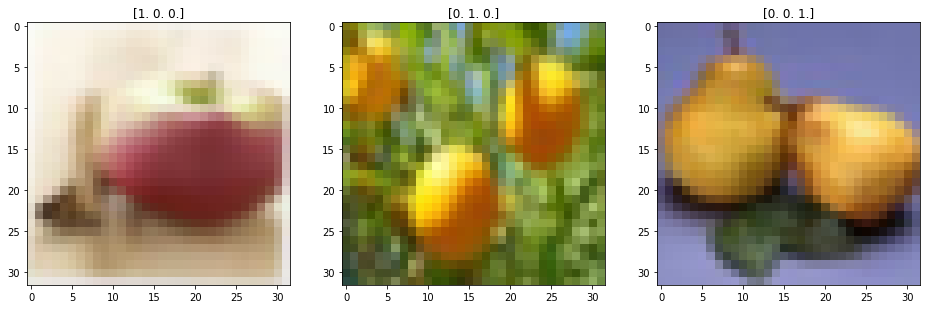

In [4]:
# Dafür plotten wir jeweils 1 Bild der drei Kategorien mit ihren One-Hot-Labeln.
fig = plt.figure(figsize=(16, 6))

apple = fig.add_subplot(1, 3, 1)
apple.set_title(y_train[0])
apple.imshow(x_train[0])

orange = fig.add_subplot(1, 3, 2)
orange.set_title(y_train[1])
orange.imshow(x_train[1])

pear = fig.add_subplot(1, 3, 3)
pear.set_title(y_train[6])
pear.imshow(x_train[6])

plt.show()

Eine Normierung der Daten liefert uns eine höhrere Accuracy.

In [5]:
# Wir müssen zuvor unsere Bilddaten in Float-Datentypen casten, dass wir Gleitkommazahlen bekommen. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Konvertieren der RGB-Werte in Werte zwischen [0;1]
x_train /= 255
x_test /= 255

# Splitten Trainingsdatensatz in Training und Validierung
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20)

### Erste Ergebnisse

![Training-accuracy](./img/acc.png)

Unseren ersten Trainingsläufe lieferten uns Ergebnisse, die wir zu diesem Zeitpunkt als sehr gut bewerteten. Nach weiterer Einarbeitung, fielen uns immer mehr Probleme und Verbessserungsansätze auf.

![Validation-Losses](./img/val_loss.png)

Somit begriffen wir, dass es bei unseren Modellen sehr oft zu einem Overffitting der Trainingsdaten kam. Über eine Optimierung sämtlicher Parameter, wie beispielsweise der Loss-function, Layers, ... wurden unsere Ergebnisse immer besser. Ein Overfitting verhinderten wir letzendlich über Dropout-Layers und ein Early-Stopping durch Beschränkung der Epochen.

Im folgenden Schritt definieren wir unser finales Modell. Wir nutzen für die Klassifizierung unserer Bilder ein **Convolutional Neural Network (CNN)**. Das Modell besteht aus vier *Convolutional Layern* und drei *Pooling Layern*. Unsere Filtergröße beträgt *3 x 3*. Wir verwenden für jede Schicht die *ReLU*-Aktivierungsfunktion. Nur unser Ausgabeschicht verwendet eine *Softmax*-Aktivierungsfunktionen. Als Error-Funktion kommt für Multiklassifizierung bestimmte *Mean_squared_errors*  zum Einsatz. Als Optimierer benutzen wir den stochastischen Optimierer *Adam*.

In [6]:
# Wir definieren unser Model über einen Stapel von Schichten. Hierzu initialisieren wir unser sequentialles Modell.
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
# Ein Dropout-Layer dient der Verhinderung eines Overfittings während des Trainungsdurch zufällige Deaktivierung
# von Neuronen (hier: 50%).
model.add(Dropout(0.5))

model.add(Conv2D(96, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.5))
# Dient der Dimensionsreduktion. Wird für Verwendung von Dense Layern benötigt.
model.add(Flatten())

# Voll verbundene Neuronen.
model.add(Dense(192, activation="relu"))
model.add(Dense(3, activation="softmax"))

# Konfiguration der Trainingsparameter.
model.compile(loss="mean_squared_error", optimizer="Adam", metrics=["accuracy"])

Zum Trainieren des Modells übergeben wir der **fit()**-Methode unsere Trainingsdaten und -Labels. Das Modell wird über 5 Epochen trainiert. Wir verwenden unsere Testdaten und -Labels zur Validierung unseres Modells nach jeder Epoche über das Argument *validation_data*. "Loss" und "Accuracy" werden standardmäßig nach jeder Epoche und nach dem Trainieren ausgegeben (verbose default: 1).

In [7]:
# Initialisieren unseres Tensorboard-Callbacks zur späteren Visualisierung unserer Metriken.
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[tensorboard])

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 3s 2ms/step - loss: 0.2110 - acc: 0.4517 - val_loss: 0.1808 - val_acc: 0.5933
Epoch 2/50
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1563 - acc: 0.6575 - val_loss: 0.1156 - val_acc: 0.7767
Epoch 3/50
1200/1200 [==============================] - 3s 2ms/step - loss: 0.1369 - acc: 0.7100 - val_loss: 0.1217 - val_acc: 0.7733
Epoch 4/50
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1270 - acc: 0.7300 - val_loss: 0.1160 - val_acc: 0.7867
Epoch 5/50
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1253 - acc: 0.7333 - val_loss: 0.1145 - val_acc: 0.7767
Epoch 6/50
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1236 - acc: 0.7267 - val_loss: 0.1056 - val_acc: 0.8000
Epoch 7/50
1200/1200 [==============================] - 2s 2ms/step - loss: 0.1207 - acc: 0.7333 - val_loss: 0.1069 - val_acc: 0.8033
Epoch 8/50
1200

Wir können die Testgenauigkeit über den Score von *evaluate()* ausgeben.

In [8]:
# Ausgeben der Test-accuracy
score = model.evaluate(x_test, y_test)

print("Test-accuracy: " + str(score[1]*100) + "%")

300/300 [==============================] - 0s 537us/step
Test-accuracy: 85.99999992052713%


Zur Visualisierung einer **Confusion Matrix** benötigen wir die Vorhersagen der Testdaten-Labels. Dafür rufen wir die Methode *predict()* auf unsere Testdaten auf. Ebenfalls wandeln wir unsere binären Test-Labels zurück, um diese mit den Vorhersagen vergleichen zu können.

In [9]:
# Vorhersagen der Testdaten-Labels.
y_pred = model.predict_classes(x_test, verbose=0)

# Umkehren der binären Klassenmatrix zu kategorischen Vektoren für Confusion Matrix.
y_test_rev = [np.argmax(y, axis=None, out=None) for y in y_test]

# Berechnen der Confusion Matrix
print(confusion_matrix(y_test_rev, y_pred))

[[85  9  6]
 [ 1 95  4]
 [ 9 13 78]]


Mittels *matplotlib* können wir unsere Trainings-, Test- History in Bezug auf Accuracy und Loss plotten.

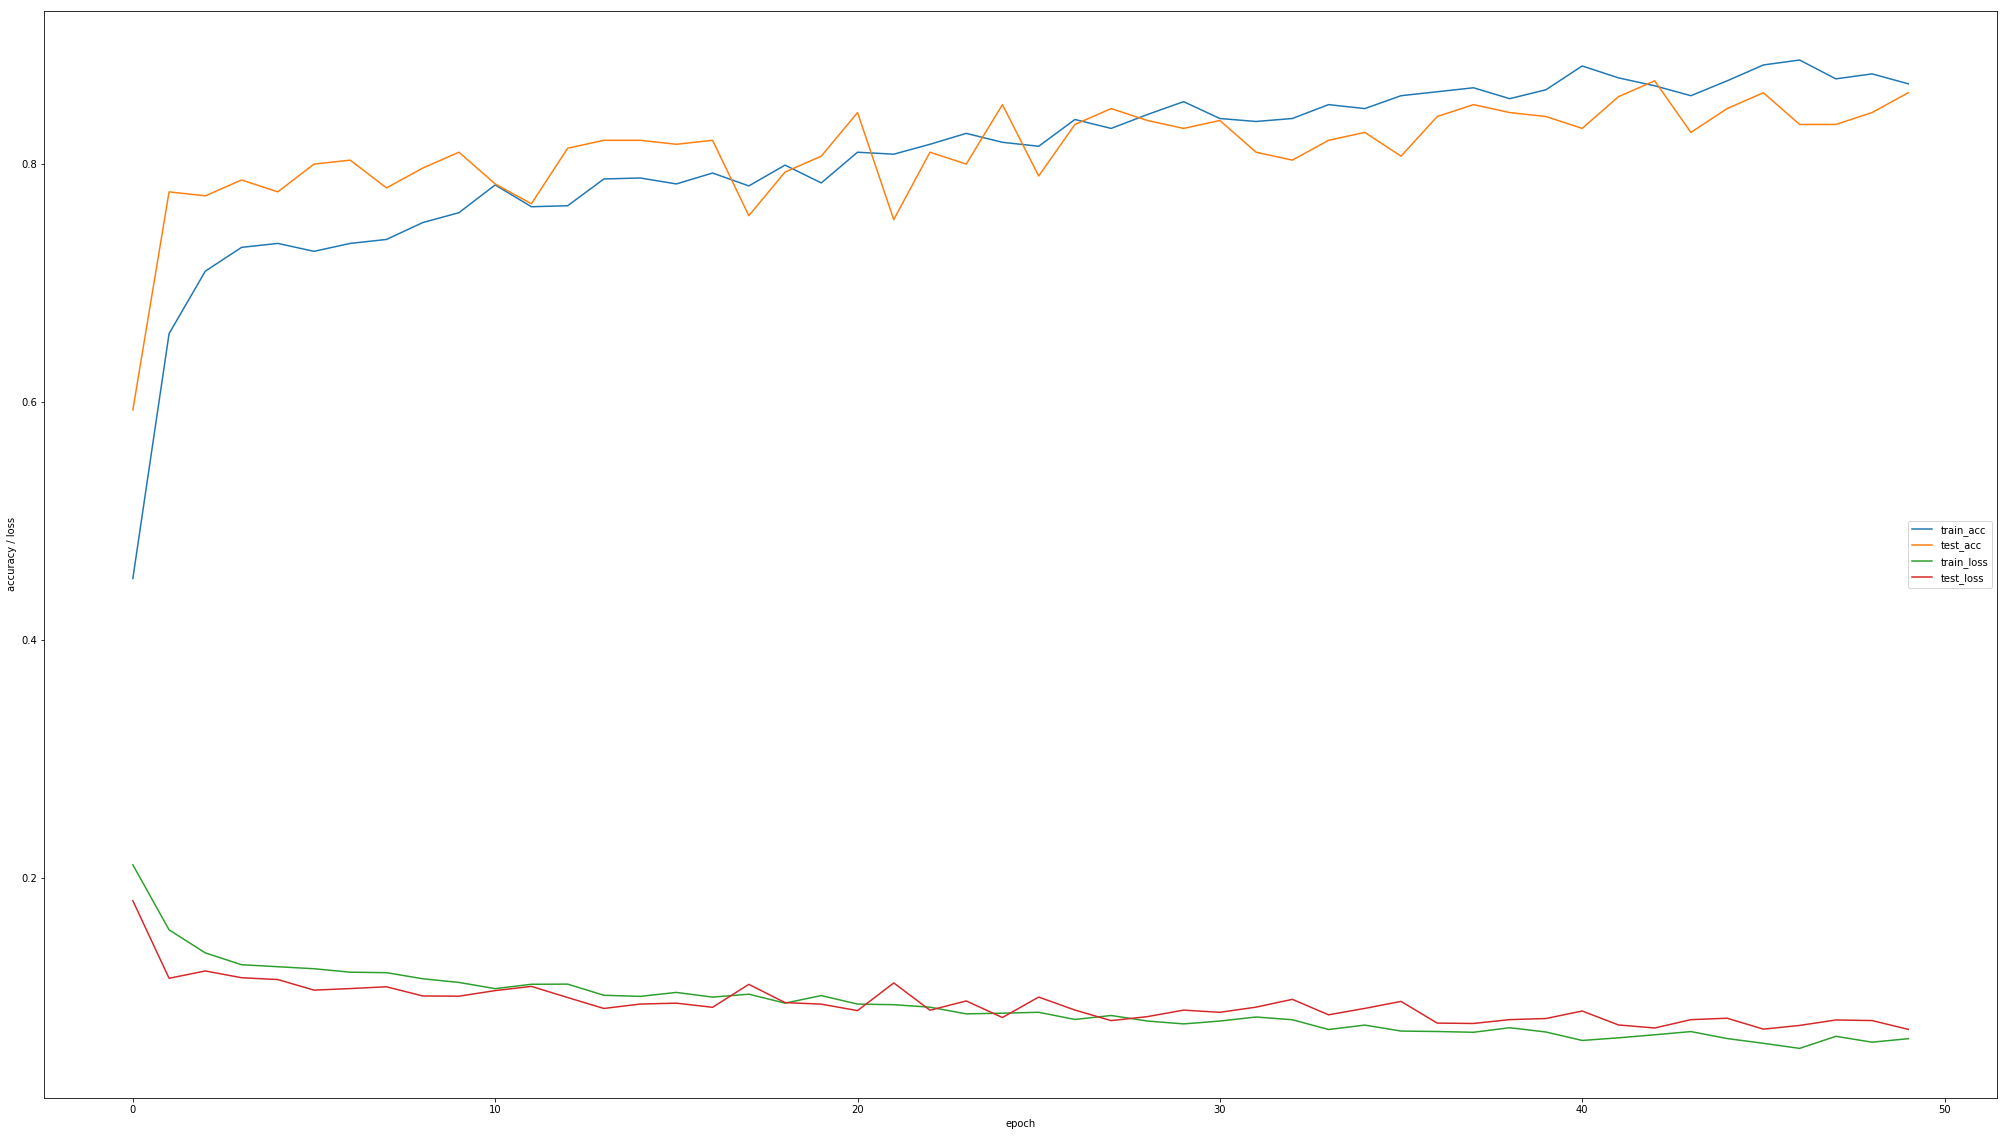

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='center right')
plt.rcParams["figure.figsize"] = (35, 20)
plt.show()

Um unser Modell für weitere Aufgaben verwenden zu können nutzen wir die **save**-Methode zur Speicherung unseres Modells als Datei.

In [ ]:
model.save("model_75_1.h5")